# Cross Validation Analysis for Principal Components of Discrimination

## PCD

The PCD extraction is done by adding neurons in the hidden layer as the SP index increases more than a certain value. This is implemented by a 3 layers feed forward neural network (input, hidden and output layers).

## Cross Validation

The cross validation is done by randomly dividing the data into a number of boxes and selecting random boxes as train, test and validation sets. The data is considered for each acquisition run, of every ship. That is, the boxes and selections are done for each acquisition run. Later, they are appended in order to train the classifier with data from every acquisition. This guarantees that most of the signal stochasticity is seen by the classifier.

## Training

For each number of PCD and for each cross validation selection, the model is trained several times, for each random initialization, in order to avoid local minima.

The data used in the cross validation are the time windows from all signals, independently of acquisition run and ship. It is likelty that train, validation and test will have signals from every run and every ship.

# Results

In [1]:
%matplotlib inline
import Sonar.SonarData as sd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas
from sklearn.externals import joblib
from sklearn import metrics
from itertools import cycle, repeat
# Network import: should be in the path if framework configured correctly
import neuralnet as nn
import PyNN.CrossValidation as PyCV
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import scipy as sc
import itertools

np.set_printoptions(precision=0, suppress=True)

# Standard styles for each class
dashes = [[],[10,10],[10,4,2,4],[10,5,100,5]] 
colors = ['b','r','g','y']
markers= ['o','s','^','d']

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.borderpad'] = 0.3
mpl.rcParams['legend.numpoints'] = 1


classes = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
noveltyclasses = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
sonarhome = os.getenv('SONARHOME')
sonarnov = os.getenv('SONARNOVELTY')
nfft = 1024
nPts = 400

/home/xavier/.virtualenvs/sonar/local/lib/python2.7/site-packages/matplotlib/__init__.py:1039: UserWarning: Bad val "pyside" on line #38
	"backend      : pyside
"
	in file "/home/xavier/.virtualenvs/sonar/local/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc"
	Key backend: Unrecognized backend string "pyside": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


## Load Data

In [2]:
data = {}
target = {}
data_nov = {}
cvPar = {}
for nov in noveltyclasses:
    fdata = sonarhome + '/data/novelty_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fdata)
    data[nov] = obj['data']
    data_nov[nov] = obj['data_nov']
    target[nov] = obj['target']
    cvPar[nov] = obj['cvPar']

## Load PCD

In [3]:
pcdnet = {}
for nov in noveltyclasses:
    filepcd = sonarnov + 'PCD/pcdcons_' + nov + '_' + str(nfft) + 'nfft.jbl'
    pcdnet[nov] = joblib.load(filepcd)

## PCD Efficiency

In [4]:
NCV = pcdnet.values()[0]['cvPar']['CVNSel'] # it should be independent of which novelty
NMaxPCD = pcdnet.values()[0]['pcdPar']['MaxPCD']
nov_avg_sps = np.zeros((len(pcdnet), NMaxPCD)) * np.nan
nov_std_sps = np.zeros((len(pcdnet), NMaxPCD)) * np.nan
nov_avg_pds = np.zeros((len(pcdnet), NMaxPCD)) * np.nan
nov_std_pds = np.zeros((len(pcdnet), NMaxPCD)) * np.nan
sps  = np.zeros((NCV, NMaxPCD)) * np.nan
pds  = np.zeros((NCV, NMaxPCD)) * np.nan
NumberOfPCDs = np.arange(1, NMaxPCD+1)
non_nov_pds = {} # dictionary per novelty. Efficiency for non-novelties 
lab = []
for inov, nov in enumerate(noveltyclasses):
    lab.append(nov)
    non_nov_pds[nov] = {}
    for nonnov in pcdnet[nov]['Classes']:
        non_nov_pds[nov][nonnov] = np.zeros((NCV, NMaxPCD)) * np.nan
    for icv in range(NCV):
        pycv = pcdnet[nov]['PCDModel'].results[icv]
        if pycv is None:
            continue
        for ipcd in range(NMaxPCD):
            trninfo = pycv.PCDNets[ipcd].trn_info
            ibst = trninfo.best_epoch if trninfo.best_epoch != 0 else -1
            for i, nonnov in enumerate(pcdnet[nov]['Classes']):
                # indexes should be in the same order as novelty[nov]['Classes']
                non_nov_pds[nov][nonnov][icv,ipcd] = trninfo.metrics['eff_val_c'+str(i)][ibst]
            sps[icv,ipcd] = trninfo.metrics['sp_val'][ibst]
            pds[icv,ipcd] = np.mean([trninfo.metrics['eff_val_c0'][ibst],
                                     trninfo.metrics['eff_val_c1'][ibst],
                                     trninfo.metrics['eff_val_c2'][ibst]])
    nov_avg_sps[inov] = np.nanmean(sps, axis=0)
    nov_std_sps[inov] = np.nanstd(sps, axis=0)
    nov_avg_pds[inov] = np.nanmean(pds, axis=0)
    nov_std_pds[inov] = np.nanstd(pds, axis=0)

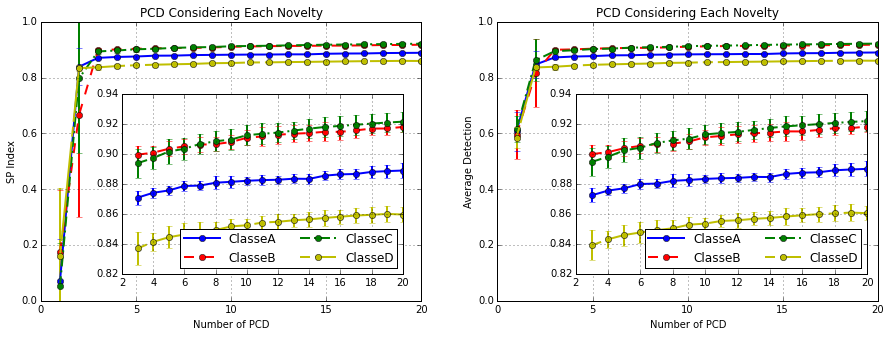

In [5]:
plt.figure(figsize=(15,5), facecolor='w')
# PLOTS
# SP
plt.subplot(1,2,1, alpha=0)
for inov, nov in enumerate(noveltyclasses):
    icls = np.nonzero(classes == nov)[0] # the class index, not the novelty index
    plt.errorbar(NumberOfPCDs, nov_avg_sps[inov], nov_std_sps[inov],marker='o',
                 color=colors[icls], dashes=dashes[icls])
plt.grid(True) 
plt.ylim([0, 1])
plt.title('PCD Considering Each Novelty')
plt.xlabel('Number of PCD')
plt.ylabel('SP Index')
ax2 = plt.axes([.2, .2, .26, .5], axisbg ='w')
for inov, nov in enumerate(noveltyclasses):
    icls = np.nonzero(classes == nov)[0] # the class index, not the novelty index
    ax2.errorbar(NumberOfPCDs[2:],nov_avg_sps[inov][2:], nov_std_sps[inov][2:],marker='o',
                 color=colors[icls], dashes=dashes[icls])
ax2.grid(True)
plt.ylim([0.82,0.94])
plt.legend(lab, loc= 'lower right', ncol=2).get_frame().set_facecolor('1')
# PD
plt.subplot(1,2,2, alpha=0)
for inov, nov in enumerate(noveltyclasses):
    icls = np.nonzero(classes == nov)[0] # the class index, not the novelty index
    plt.errorbar(NumberOfPCDs, nov_avg_pds[inov], nov_std_pds[inov],marker='o',
                 color=colors[icls], dashes=dashes[icls])
plt.grid(True) 
plt.ylim([0, 1])
plt.title('PCD Considering Each Novelty')
plt.xlabel('Number of PCD')
plt.ylabel('Average Detection')
ax2 = plt.axes([.62, .2, .27, .5], axisbg ='w')
for inov, nov in enumerate(noveltyclasses):
    icls = np.nonzero(classes == nov)[0] # the class index, not the novelty index
    ax2.errorbar(NumberOfPCDs[2:],nov_avg_pds[inov][2:], nov_std_pds[inov][2:],marker='o',
                 color=colors[icls], dashes=dashes[icls])
ax2.grid(True)
plt.legend(lab, loc= 'lower right', ncol=2,).get_frame().set_facecolor('1')
plt.ylim([0.82,0.94]);

## PCD Class Detection Per Novelty 

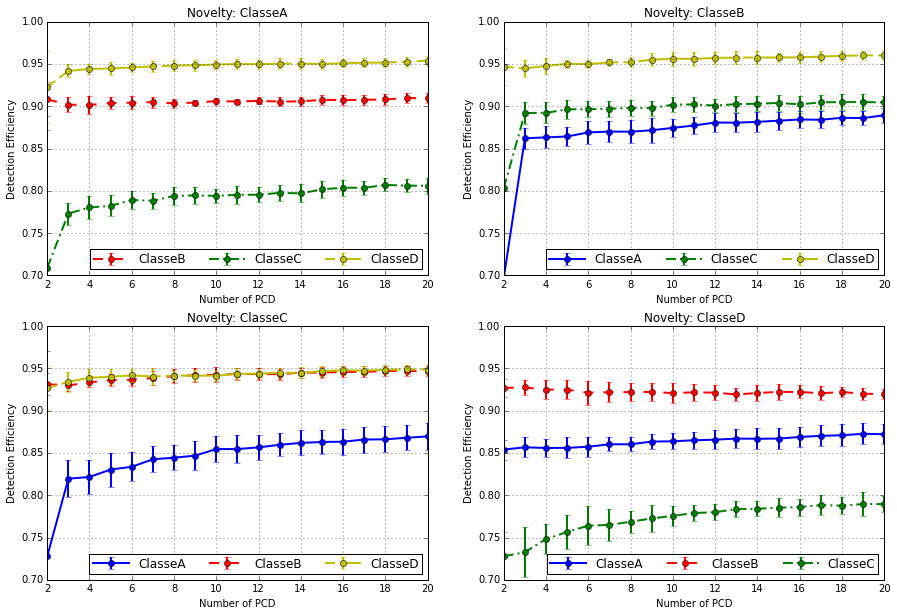

In [6]:
plt.figure(figsize=(15,10), facecolor='w')
for inov, nov in enumerate(pcdnet.keys()):
    plt.subplot(2,2,inov+1)
    # Loop over detected classes
    for nonnov in non_nov_pds[nov]:
        icls = np.nonzero(classes == nonnov)[0] # the class index, not the novelty index
        avg_pds = np.nanmean(non_nov_pds[nov][nonnov], axis=0)
        std_pds = np.nanstd(non_nov_pds[nov][nonnov], axis=0)        
        plt.errorbar(NumberOfPCDs[1:],avg_pds[1:], std_pds[1:], marker = 'o',
                     color=colors[icls], dashes=dashes[icls], label=nonnov)
    plt.ylim([0.7,1])
    plt.grid(True)
    plt.xlabel('Number of PCD')
    plt.ylabel('Detection Efficiency')
    plt.title('Novelty: ' + nov)
    plt.legend(loc='lower right',ncol=3).get_frame().set_facecolor('1')

## Performance Analysis

In [7]:
npcd = 18

### Network Simulation

In [10]:
Y = {}
for novcls in noveltyclasses:
    Y[novcls] = {}
    NCV = cvPar[novcls]['CVNSel']
    # Over CV
    for icv in range(NCV):
        Y[novcls][icv] = {}
        if pcdnet[novcls]['PCDModel'].results[icv] is None:
            continue
        nnet = pcdnet[novcls]['PCDModel'].results[icv].PCDNets[npcd-1]
        Y[novcls][icv]['Output'] = nnet.feedforward(data[novcls])
        Y[novcls][icv]['OutNov'] = nnet.feedforward(data_nov[novcls])
        Y[novcls][icv]['ITest'] = nnet.trn_info.ival
        #Y[novcls][icv]['ITest'] = np.arange(X.shape[0])

### Performance Over Threshold

In [15]:
float(effsp[0,0])

0.8857654387595807

ClasseA   Trigger: 90.12 +- 0.77, Novelty: 26.24 +- 5.68, at thrs: 0.610  accuracy: 84.50 +- 0.48  sp: 82.06 +- 0.62
ClasseB   Trigger: 90.02 +- 1.18, Novelty: 35.09 +- 1.95, at thrs: 0.760  accuracy: 86.24 +- 1.03  sp: 84.44 +- 1.13
ClasseC   Trigger: 90.08 +- 1.13, Novelty: 28.92 +- 3.80, at thrs: 0.770  accuracy: 86.62 +- 1.04  sp: 85.45 +- 0.96
ClasseD   Trigger: 90.02 +- 0.90, Novelty: 24.02 +- 2.83, at thrs: 0.510  accuracy: 82.39 +- 0.92  sp: 79.73 +- 1.06


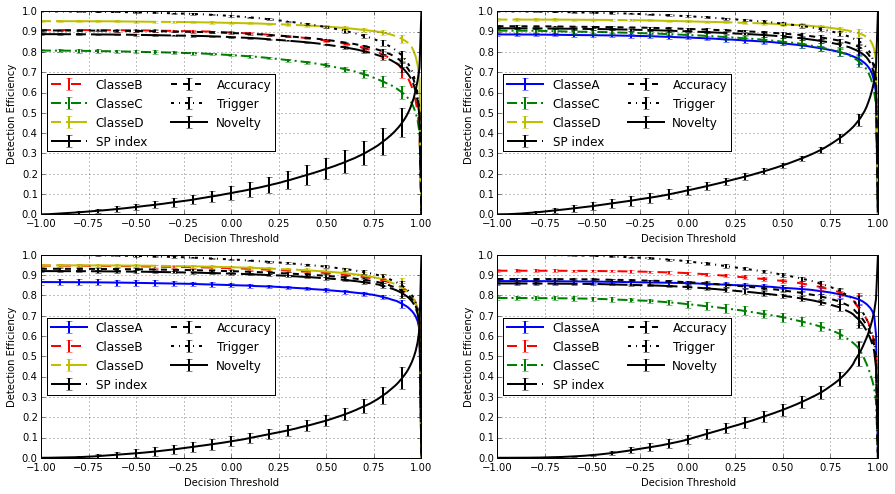

In [31]:
plt.figure(figsize=(15,8), facecolor='w')
thrs = np.arange(-1,1.25,0.01)
det_target = 0.9
# Loop over novelties
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    # PLot Known classes
    effnov = np.zeros((NCV, len(thrs)))*np.nan  # novely efficiency
    effclass  = np.zeros((T.shape[1], NCV, len(thrs)))
    for iout in range(T.shape[1]):
        # Loop over cross-validation
        tpr = np.zeros((NCV, len(thrs))) * np.nan # true positive rate
        for icv in range(NCV):
            Yout = Y[novcls][icv]['Output']
            itst = Y[novcls][icv]['ITest']
            # Loop over thresholds
            for ithr, thr in enumerate(thrs):
                # True Positive: greater than the threshold and the other neurons.
                TP = np.sum((Yout[itst, iout]>=thr) & (np.argmax(Yout[itst], axis=1) == iout) & (T[itst, iout] == 1))
                tpr[icv,ithr] = TP / float(np.sum((T[itst, iout] == 1)))
        effclass[iout] = tpr
        # Plot
        icls = np.nonzero(classes == pcdnet[novcls]['Classes'][iout])[0]
        plt.errorbar(thrs, np.nanmean(tpr, axis=0), np.nanstd(tpr, axis=0), dashes=dashes[icls],color=colors[icls],
                     errorevery=10, label=pcdnet[novcls]['Classes'][iout])
    # Plot SP
    effsp = np.sqrt(np.power(np.prod(effclass, axis=0), 1.0/T.shape[1]) * np.mean(effclass, axis=0))
    plt.errorbar(thrs, np.mean(effsp, axis=0), np.std(effsp, axis=0), fmt='k', dashes=[30, 5, 10, 5],
                 errorevery=10, label='SP index')
    # Plot total accuracy (efficiency of known-classes)
    efftot = np.zeros((NCV, len(thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        Yout = Y[novcls][icv]['Output']
        itst = Y[novcls][icv]['ITest']
        # Loop over thresholds
        for ithr, thr in enumerate(thrs):
            # True Positive: greater than the threshold and correct neuron.
            
            TP = np.sum(((np.max(Yout, axis=1) >= thr) & (np.argmax(Yout, axis=1) == np.argmax(T, axis=1)))[itst])
            
            #TP = np.sum((np.max(Yout, axis=1)[itst]>=thr))
            efftot[icv,ithr] = TP / float(itst.shape[0])
    plt.errorbar(thrs, np.mean(efftot, axis=0), np.std(efftot, axis=0), fmt='--k',
                 errorevery=10, label='Accuracy')

    # System trigger (detection rate)
    efftrg = np.zeros((NCV, len(thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        Yout = Y[novcls][icv]['Output']
        itst = Y[novcls][icv]['ITest']
        # Loop over thresholds
        for ithr, thr in enumerate(thrs):
            # Just need an output greater than the thrshold
            TP = np.sum((np.max(Yout, axis=1)[itst]>=thr))
            efftrg[icv,ithr] = TP / float(itst.shape[0])
    plt.errorbar(thrs, np.mean(efftrg, axis=0), np.std(efftrg, axis=0), fmt='-.k',
                 errorevery=10, label='Trigger')
    
    # Plot Novelty
    for icv in range(NCV):
        Ynov = Y[novcls][icv]['OutNov']
        effnov[icv] = np.array([np.sum(np.max(Ynov, axis=1) < thr) for thr in thrs], 'f')/Ynov.shape[0]
    plt.errorbar(thrs, np.nanmean(effnov, axis=0), np.nanstd(effnov, axis=0),
                 fmt='k-', errorevery=10, label='Novelty')
    # PRINT INFO
    idx = np.nonzero(np.mean(efftrg, axis=0) >= det_target)[0][-1]
    print novcls, '  Trigger: %.2f +- %.2f, Novelty: %.2f +- %.2f, at thrs: %.3f'%(np.mean(efftrg, axis=0)[idx]*100,
                                                                                   np.std (efftrg, axis=0)[idx]*100,
                                                                                   np.mean(effnov, axis=0)[idx]*100,
                                                                                   np.std (effnov, axis=0)[idx]*100,
                                                                                   thrs[idx]),
    print ' accuracy: %.2f +- %.2f'%(np.mean(efftot, axis=0)[idx]*100, np.std(efftot, axis=0)[idx]*100), 
    print ' sp: %.2f +- %.2f'%(np.mean(effsp, axis=0)[idx]*100, np.std(effsp, axis=0)[idx]*100)
    # Plot aspects
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.arange(-1,1.25,0.25))
    plt.xlim([-1,1])
    plt.ylim([0,1])
    plt.grid()
    plt.xlabel('Decision Threshold')
    plt.ylabel('Detection Efficiency')
    plt.legend(loc='center left', ncol=2).get_frame().set_facecolor('1')

## Final PCD 

From the cross validation analysis, we can estimate the statistical effect on the PCD performance, but we still need to find a deterministic basis for the PCD transformation. Only one network out of the N cross validation tests is elected the winner and used in later analysis. This selection depends on the purpose of the PCD.

Although the PCD aims for detection, the idea is to find the best discrimination directions that characterizes the known classes. The novelty itself is later analyzed considering a neural classifier over the data projection onto the PCD. For that reason, the final PCD will be selected considering the network that best characterizes the detection of the entire dataset of the known classes.

In [30]:
finalNet = {}
finalSim = {}
for inov, novcls in enumerate(noveltyclasses):
    print novcls, ': ',
    finalNet[novcls] = None
    bestPerf = 0
    sps = np.zeros(len(Y[novcls]))*np.nan
    tpr = np.zeros(len(Y[novcls]))*np.nan
    mse = np.zeros(len(Y[novcls]))*np.nan
    for icv in range(len(Y[novcls])):
        if not len(Y[novcls][icv]):
            continue
        Yout = Y[novcls][icv]['Output']
        T = target[novcls]
        #itst = Y[novcls][icv]['ITest']        
        itst = np.array([True] * T.shape[0])
        effs = np.zeros(len(pcdnet[novcls]['Classes']))
        err = 0
        for iout in range(len(pcdnet[novcls]['Classes'])):
            TP = np.sum((np.argmax(Yout[itst], axis=1) == iout) & (T[itst, iout] == 1))
            effs[iout] = TP / float(np.sum((T[itst, iout] == 1)))
            err = np.sum(np.power(Yout[itst, iout] - T[itst, iout], 2)) + err
        mse[icv] = err / itst.shape[0]
        sps[icv] = np.sqrt(np.power(np.prod(effs), 1./len(effs)) * np.mean(effs))
        tpr[icv] = np.mean(effs)
    iwinner = np.nanargmax(sps)
    #iwinner = np.nanargmin(mse)    
    finalNet[novcls] = pcdnet[novcls]['PCDModel'].results[iwinner].PCDNets[npcd-1]
    finalSim[novcls] = Y[novcls][iwinner]
    print 'SP = %.3f, PD = %.3f, MSE = %.3f'%(sps[iwinner]*100, tpr[iwinner]*100, mse[iwinner]), ' for #cv ', iwinner

ClasseA :  SP = 94.408, PD = 94.431, MSE = 0.344  for #cv  2
ClasseB :  SP = 96.111, PD = 96.120, MSE = 0.242  for #cv  4
ClasseC :  SP = 96.402, PD = 96.415, MSE = 0.211  for #cv  0
ClasseD :  SP = 92.439, PD = 92.462, MSE = 0.433  for #cv  2


### PCD Distributions

In [33]:
workcls = 'ClasseB'
W = finalNet[workcls].W[0]
X = data[workcls]
Xnov = data_nov[workcls]
Xpcd = pandas.DataFrame(W.dot(X.transpose()).transpose())
XnovPcd = pandas.DataFrame(W.dot(Xnov.transpose()).transpose())

#### PCD Correlation

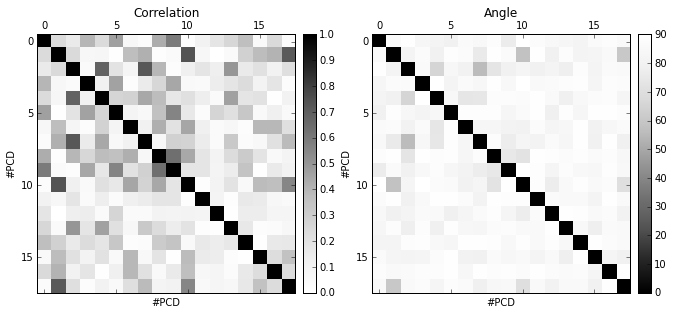

In [34]:
plt.figure(figsize=(11,5), facecolor='w')
plt.subplot(1,2,1)
Coef = Xpcd.corr()
ms = plt.matshow(np.abs(Coef), cmap=plt.cm.Greys, vmin=0, vmax=1, fignum=0)
plt.xlabel('#PCD')
plt.ylabel('#PCD')
plt.title('Correlation')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(ms, cax=cax);
# Angle
Cang = np.zeros(Coef.shape)
for i in range(Cang.shape[0]):
    for j in range(Cang.shape[0]):
        dot = W[i,:].dot(W[j,:])
        norm_i = np.linalg.norm(W[i,:],2)
        norm_j = np.linalg.norm(W[j,:],2)
        Cang[i,j] = np.degrees(np.arccos(dot/norm_i/norm_j))
plt.subplot(1,2,2)
Cang[np.isnan(Cang)] = 0
Cang[(Cang > 90)&(Cang <= 180)] = Cang[(Cang > 90)&(Cang < 180)] - 180
Cang[(Cang > 180)&(Cang <= 270)]= Cang[(Cang > 180)&(Cang <= 270)] - 180
Cang = np.abs(Cang)
ms = plt.matshow(np.abs(Cang), cmap=plt.cm.Greys_r, vmin=0, vmax=90, fignum=0)
plt.xlabel('#PCD')
plt.ylabel('#PCD')
plt.title('Angle')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(ms, cax=cax);

#### KDE Distributions

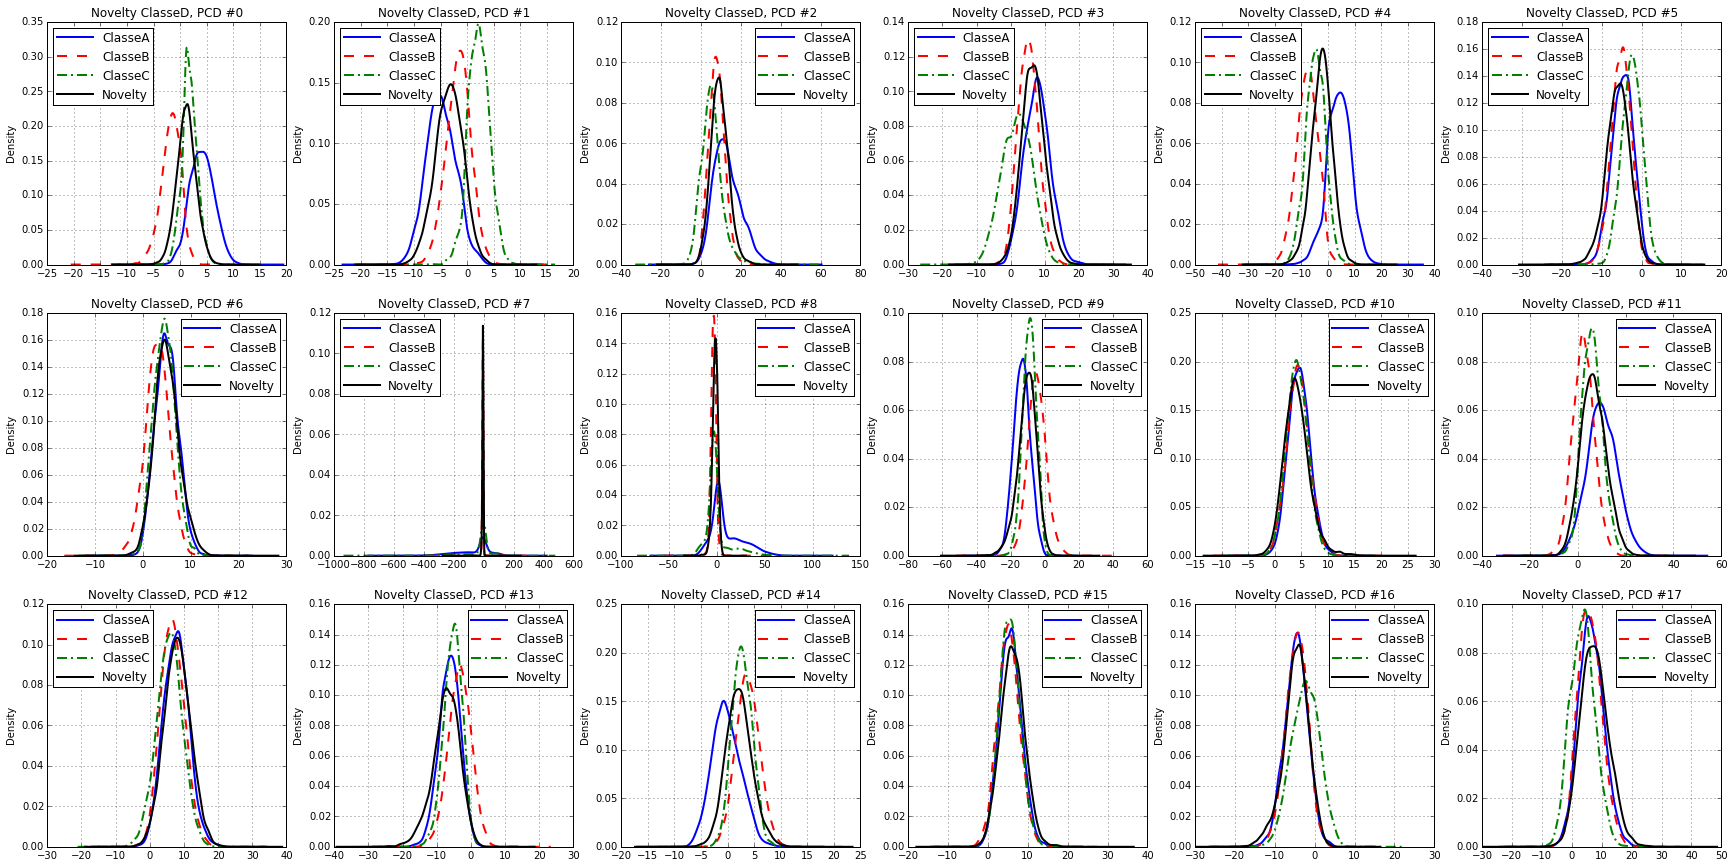

In [16]:
Nx = 6
Ny = int(np.floor(Xpcd.shape[1]/float(Nx)))+1
plt.figure(figsize=(Nx*5,Ny*5), facecolor='w')
for ipcd in range(Xpcd.shape[1]):
    plt.subplot(Ny, Nx, ipcd+1)
    for cls in range(len(data[workcls]['Labels'])):
        icls = np.nonzero(classes == data[workcls]['Labels'][cls])[0]
        T = data[workcls]['Target']
        idx = np.nonzero(T[:, cls] == 1)[0]
        Xpcd.loc[idx, ipcd].plot(kind='kde', color = colors[icls],sharex=False,
                                 dashes=dashes[icls], label=data[workcls]['Labels'][cls])
    XnovPcd.loc[:, ipcd].plot(kind='kde', color = 'k',sharex=False,label='Novelty')
    #if ipcd in [12,13,16] and workcls == 'ClasseA': plt.xlim([-80,80])
    #if ipcd in [12] and workcls == 'ClasseC': plt.xlim([-100,100])
    plt.title('Novelty ' + workcls +', PCD #'+str(ipcd))
    plt.legend(numpoints=1, loc='best').get_frame().set_facecolor('1')

#### 2D Distributions

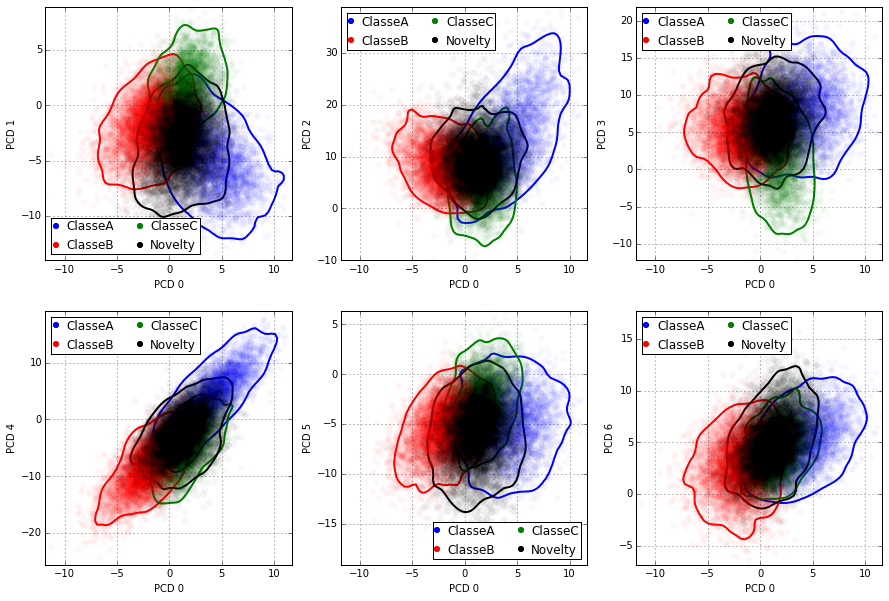

In [17]:
from scipy.stats import gaussian_kde
Nx = 3
Ny = 2
max_fig = 6
plt.figure(figsize=(Nx*5,Ny*5), facecolor='w')
for ifig, dims in enumerate(itertools.combinations(range(Xpcd.shape[1]),2)):
    if ifig == max_fig: break
    plt.subplot(Ny,Nx, ifig+1)
    lab = []
    for iout in range(len(data[workcls]['Labels'])):
        icls = np.nonzero(classes == data[workcls]['Labels'][iout])[0]
        T = data[workcls]['Target']
        idx = np.nonzero(T[:, iout] == 1)[0]
        xbins = np.linspace(Xpcd.loc[idx, dims[0]].min(), Xpcd.loc[idx, dims[0]].max(), 50)
        ybins = np.linspace(Xpcd.loc[idx, dims[1]].min(), Xpcd.loc[idx, dims[1]].max(), 50)
        dsx, dsy = np.meshgrid(xbins, ybins)
        ds = gaussian_kde(Xpcd.loc[idx[np.random.randint(0,idx.shape[0], 1000)], dims].transpose())
        pos = np.vstack([dsx.ravel(),dsy.ravel()])
        Z = np.reshape(ds(pos).T, dsx.shape)
        Z = Z / np.sum(Z)
        plt.plot(Xpcd.loc[idx, dims[0]], Xpcd.loc[idx, dims[1]], 'o', alpha=.03,markeredgecolor='none',
                 color =colors[icls] ,label=data[workcls]['Labels'][iout])
        plt.contour(dsx, dsy, Z, levels=[np.max(Z)*0.05], colors=colors[icls])
        plt.grid(True)
        lab.append(plt.Line2D([1],[1],color=colors[icls],marker='o', markeredgecolor='none'))

    # Novelty
    xbins = np.linspace(XnovPcd.loc[:, dims[0]].min(), XnovPcd.loc[:, dims[0]].max(), 50)
    ybins = np.linspace(XnovPcd.loc[:, dims[1]].min(), XnovPcd.loc[:, dims[1]].max(), 50)
    dsx, dsy = np.meshgrid(xbins, ybins)
    ds = gaussian_kde(XnovPcd.loc[np.random.randint(0,XnovPcd.shape[0], 1000), dims].transpose())
    pos = np.vstack([dsx.ravel(),dsy.ravel()])
    Z = np.reshape(ds(pos).T, dsx.shape)
    Z = Z / np.sum(Z)    
    plt.plot(XnovPcd.loc[:, dims[0]], XnovPcd.loc[:, dims[1]], 'ok', alpha=.03,label='Novelty')
    plt.contour(dsx, dsy, Z, levels=[np.max(Z)*0.05], colors='k')
    lab.append(plt.Line2D([1],[1],color='k',marker='o',markeredgecolor='none'))    
    plt.xlabel('PCD '+str(dims[0]))
    plt.ylabel('PCD '+str(dims[1]))
    labtxt = np.concatenate((data[workcls]['Labels'],['Novelty']))
    h_leg = plt.legend(lab, labtxt, numpoints=1, loc='best', ncol=2, handlelength=0.3,borderpad=0.2)
    h_leg.get_frame().set_facecolor('1')    